# Benchmarking and Performance

This notebook demonstrates Pulsim's benchmarking framework and performance features.

## Contents
1. BenchmarkResult Structure
2. Timing Simulations
3. SIMD Detection
4. Performance Comparison
5. Export Functions

In [5]:
import pulsim as ps
import numpy as np
import matplotlib.pyplot as plt
import time

## 1. BenchmarkResult Structure

The `BenchmarkResult` and `BenchmarkTiming` classes track performance metrics.

In [6]:
# BenchmarkTiming structure
timing = ps.BenchmarkTiming()

print("BenchmarkTiming fields:")
print(f"  name:       '{timing.name}'")
print(f"  total_ms:   {timing.total_ms}")
print(f"  average_ms: {timing.average_ms}")
print(f"  min_ms:     {timing.min_ms}")
print(f"  max_ms:     {timing.max_ms}")
print(f"  iterations: {timing.iterations}")

BenchmarkTiming fields:
  name:       ''
  total_ms:   <bound method pybind11_detail_function_record_v1_system_libcpp_abi1.total_ms of <pulsim._pulsim.BenchmarkTiming object at 0x1114ca630>>
  average_ms: <bound method pybind11_detail_function_record_v1_system_libcpp_abi1.average_ms of <pulsim._pulsim.BenchmarkTiming object at 0x1114ca630>>
  min_ms:     <bound method pybind11_detail_function_record_v1_system_libcpp_abi1.min_ms of <pulsim._pulsim.BenchmarkTiming object at 0x1114ca630>>
  max_ms:     <bound method pybind11_detail_function_record_v1_system_libcpp_abi1.max_ms of <pulsim._pulsim.BenchmarkTiming object at 0x1114ca630>>
  iterations: 0


In [7]:
# BenchmarkResult structure
result = ps.BenchmarkResult()

print("BenchmarkResult fields:")
print(f"  circuit_name:        '{result.circuit_name}'")
print(f"  num_nodes:           {result.num_nodes}")
print(f"  num_devices:         {result.num_devices}")
print(f"  num_timesteps:       {result.num_timesteps}")
print(f"  simulation_time:     {result.simulation_time}")
print(f"  timesteps_per_second:{result.timesteps_per_second}")

BenchmarkResult fields:
  circuit_name:        ''
  num_nodes:           0
  num_devices:         0
  num_timesteps:       0
  simulation_time:     0.0
  timesteps_per_second:<bound method pybind11_detail_function_record_v1_system_libcpp_abi1.timesteps_per_second of <pulsim._pulsim.BenchmarkResult object at 0x111496130>>


## 2. Timing Simulations

Measure simulation performance for various circuit sizes.

In [8]:
def build_resistor_ladder(n_stages):
    """Build an n-stage resistor ladder network."""
    ckt = ps.Circuit()
    gnd = ckt.ground()
    
    nodes = [ckt.add_node(f"n{i}") for i in range(n_stages + 1)]
    
    # Voltage source
    ckt.add_voltage_source("V1", nodes[0], gnd, 10.0)
    
    # Series resistors
    for i in range(n_stages):
        ckt.add_resistor(f"Rs{i}", nodes[i], nodes[i+1], 1000.0)
        ckt.add_resistor(f"Rp{i}", nodes[i+1], gnd, 2000.0)
    
    return ckt

def benchmark_dc_analysis(ckt, name=""):
    """Benchmark DC analysis and return timing."""
    start = time.perf_counter()
    result = ps.dc_operating_point(ckt)
    elapsed = time.perf_counter() - start
    
    return {
        'name': name,
        'nodes': ckt.num_nodes(),
        'system_size': ckt.system_size(),
        'time': elapsed,
        'success': result.success,
        'iterations': result.newton_result.iterations
    }

# Test with small circuit
ckt_test = build_resistor_ladder(5)
result = benchmark_dc_analysis(ckt_test, "5-stage ladder")

print(f"Benchmark: {result['name']}")
print(f"  Nodes: {result['nodes']}")
print(f"  System size: {result['system_size']}")
print(f"  Time: {result['time']*1000:.3f} ms")
print(f"  Iterations: {result['iterations']}")

Benchmark: 5-stage ladder
  Nodes: 6
  System size: 7
  Time: 0.135 ms
  Iterations: 2


In [9]:
# Benchmark various sizes
stages = [5, 10, 20, 50, 100, 200]
benchmark_results = []

print("DC Analysis Benchmark:")
print("=" * 60)
print(f"{'Stages':<10} {'Nodes':<10} {'Time (ms)':<15} {'Iter':<10}")
print("-" * 60)

for n in stages:
    ckt = build_resistor_ladder(n)
    res = benchmark_dc_analysis(ckt, f"{n}-stage")
    benchmark_results.append(res)
    
    print(f"{n:<10} {res['nodes']:<10} {res['time']*1000:<15.3f} {res['iterations']:<10}")

DC Analysis Benchmark:
Stages     Nodes      Time (ms)       Iter      
------------------------------------------------------------
5          6          0.035           2         
10         11         0.034           2         
20         21         0.036           2         
50         51         0.059           2         
100        101        0.105           2         
200        201        0.162           2         


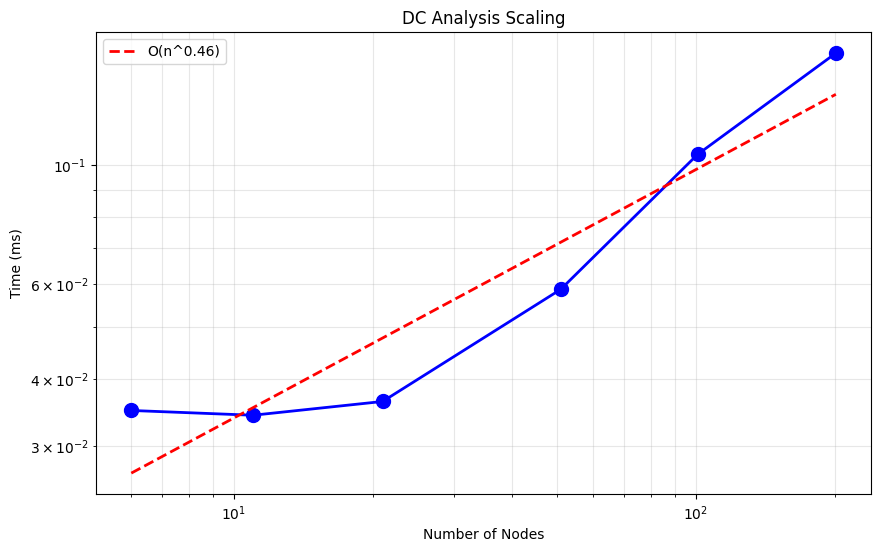


Scaling exponent: 0.46
(O(n²) would be 2.0, O(n³) would be 3.0)


In [10]:
# Plot scaling
nodes = [r['nodes'] for r in benchmark_results]
times = [r['time'] * 1000 for r in benchmark_results]

plt.figure(figsize=(10, 6))
plt.loglog(nodes, times, 'bo-', markersize=10, linewidth=2)

# Fit power law
coeffs = np.polyfit(np.log10(nodes), np.log10(times), 1)
nodes_fit = np.array([min(nodes), max(nodes)])
times_fit = 10**(coeffs[1]) * nodes_fit**coeffs[0]
plt.loglog(nodes_fit, times_fit, 'r--', linewidth=2, label=f'O(n^{coeffs[0]:.2f})')

plt.xlabel('Number of Nodes')
plt.ylabel('Time (ms)')
plt.title('DC Analysis Scaling')
plt.legend()
plt.grid(True, which='both', alpha=0.3)
plt.show()

print(f"\nScaling exponent: {coeffs[0]:.2f}")
print(f"(O(n²) would be 2.0, O(n³) would be 3.0)")

## 3. SIMD Detection

Pulsim can detect and use SIMD (Single Instruction Multiple Data) instructions for vectorized operations.

In [11]:
# Detect SIMD level
simd_level = ps.detect_simd_level()
vector_width = ps.simd_vector_width()

print("SIMD Capabilities:")
print(f"  SIMD Level: {simd_level}")
print(f"  Vector Width: {vector_width} elements")

# Available SIMD levels (architecture dependent)
print("\nAvailable SIMDLevel values:")
for attr in dir(ps.SIMDLevel):
    if not attr.startswith('_'):
        level = getattr(ps.SIMDLevel, attr)
        marker = "→" if level == simd_level else " "
        print(f"  {marker} {attr}")

SIMD Capabilities:
  SIMD Level: SIMDLevel.NEON
  Vector Width: 2 elements

Available SIMDLevel values:
    AVX
    AVX2
    AVX512
  → NEON
    None_
    SSE2
    SSE4
    name
    value


## 4. Performance Comparison

Compare transient simulation performance.

In [12]:
def benchmark_transient(ckt, t_stop, dt, name=""):
    """Benchmark transient simulation."""
    x0 = np.zeros(ckt.system_size())
    x0[0] = 1.0  # Initial voltage
    
    start = time.perf_counter()
    times, states, success, msg = ps.run_transient(ckt, 0.0, t_stop, dt, x0)
    elapsed = time.perf_counter() - start
    
    return {
        'name': name,
        'time': elapsed,
        'timesteps': len(times),
        'success': success,
        'steps_per_sec': len(times) / elapsed if elapsed > 0 else 0
    }

# Build RC circuit
def build_rc(R, C):
    ckt = ps.Circuit()
    gnd = ckt.ground()
    n_in = ckt.add_node("v_in")
    n_out = ckt.add_node("v_out")
    ckt.add_voltage_source("V1", n_in, gnd, 1.0)
    ckt.add_resistor("R1", n_in, n_out, R)
    ckt.add_capacitor("C1", n_out, gnd, C)
    return ckt

# Benchmark different timestep counts
ckt_rc = build_rc(1000, 1e-6)
tau = 1000 * 1e-6  # 1ms
t_stop = 5 * tau

timestep_counts = [100, 500, 1000, 5000, 10000]
transient_results = []

print("Transient Simulation Benchmark:")
print("=" * 60)
print(f"{'Timesteps':<12} {'Time (ms)':<12} {'Steps/sec':<15}")
print("-" * 60)

for n_steps in timestep_counts:
    dt = t_stop / n_steps
    res = benchmark_transient(ckt_rc, t_stop, dt, f"{n_steps} steps")
    transient_results.append(res)
    
    print(f"{n_steps:<12} {res['time']*1000:<12.2f} {res['steps_per_sec']:<15.0f}")

Transient Simulation Benchmark:
Timesteps    Time (ms)    Steps/sec      
------------------------------------------------------------
100          0.67         152981         
500          3.11         161257         
1000         5.72         174924         
5000         28.65        174585         
10000        56.74        176280         


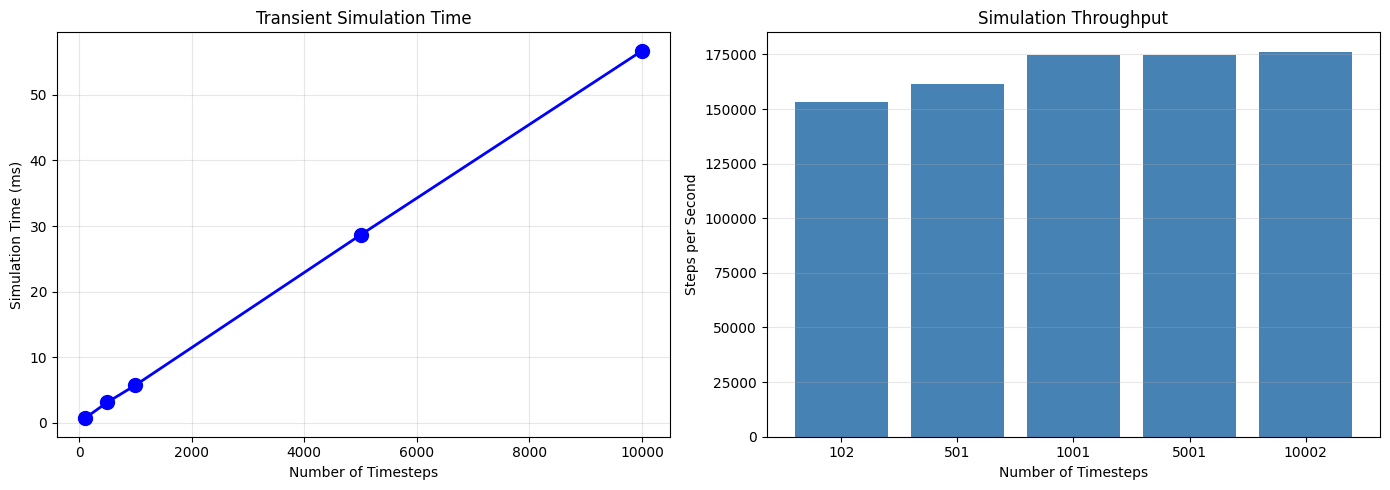

In [13]:
# Plot transient benchmark results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

steps = [r['timesteps'] for r in transient_results]
times = [r['time'] * 1000 for r in transient_results]
rates = [r['steps_per_sec'] for r in transient_results]

# Time vs timesteps
axes[0].plot(steps, times, 'bo-', markersize=10, linewidth=2)
axes[0].set_xlabel('Number of Timesteps')
axes[0].set_ylabel('Simulation Time (ms)')
axes[0].set_title('Transient Simulation Time')
axes[0].grid(True, alpha=0.3)

# Steps per second
axes[1].bar(range(len(rates)), rates, color='steelblue')
axes[1].set_xticks(range(len(rates)))
axes[1].set_xticklabels([str(s) for s in steps])
axes[1].set_xlabel('Number of Timesteps')
axes[1].set_ylabel('Steps per Second')
axes[1].set_title('Simulation Throughput')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 5. Export Functions

Benchmark results can be exported to CSV or JSON.

In [14]:
# Create a BenchmarkResult
bench = ps.BenchmarkResult()
bench.circuit_name = "RC Circuit Transient"
bench.num_nodes = ckt_rc.num_nodes()
bench.num_devices = ckt_rc.num_devices()

# Export to CSV - takes a list of results, returns string
csv_content = ps.export_benchmark_csv([bench])
print("CSV Export:")
print(csv_content)

# Export to JSON - takes a list of results, returns string
json_content = ps.export_benchmark_json([bench])
print("\nJSON Export:")
print(json_content)

CSV Export:
circuit_name,num_nodes,num_devices,num_timesteps,avg_ms,min_ms,max_ms,peak_memory_kb,throughput
RC Circuit Transient,2,3,0,0.000,9223372036854.775,0.000,0,0


JSON Export:
{
  "benchmarks": [
    {
      "circuit_name": "RC Circuit Transient",
      "num_nodes": 2,
      "num_devices": 3,
      "num_timesteps": 0,
      "avg_ms": 0.000,
      "min_ms": 9223372036854.775,
      "max_ms": 0.000,
      "peak_memory_kb": 0,
      "throughput": 0
    }
  ]
}



## Summary

### Benchmark Classes

| Class | Purpose |
|-------|---------|
| `BenchmarkTiming` | Detailed timing breakdown (total_ms, average_ms, min_ms, max_ms) |
| `BenchmarkResult` | Complete benchmark results (circuit_name, num_nodes, simulation_time) |

### Performance Functions

```python
# SIMD detection
level = ps.detect_simd_level()  # Returns SIMDLevel enum
width = ps.simd_vector_width()  # Vector width in elements

# Create benchmark result
bench = ps.BenchmarkResult()
bench.circuit_name = "My Circuit"
bench.num_nodes = circuit.num_nodes()
bench.num_devices = circuit.num_devices()

# Export - takes a list of results, returns string
csv_str = ps.export_benchmark_csv([bench])
json_str = ps.export_benchmark_json([bench])
```

### Performance Tips

1. **Circuit size**: Complexity scales roughly O(n²) to O(n³) with system size
2. **Timestep**: Smaller timesteps = more iterations but better accuracy
3. **SIMD**: Use a CPU with AVX2/AVX512 (x86) or NEON (ARM) for best vectorization
4. **Tolerances**: Tighter tolerances = more Newton iterations

**Back to:** [Getting Started](01_getting_started.ipynb)